In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [26]:
df = pd.read_csv("./Gia SMP va SMPcap 2021(Giá thị trường SMP).csv", encoding="latin-1", sep =';')

In [4]:
feats = ['7', '8', '9']
df[feats]

,7,8,9
0,964.4,964.4,964.4
1,1019.7,1019.7,1019.7
2,988.4,988.4,988.4
3,1002.0,1002.0,1002.1
4,1061.5,1061.5,1061.5
...,...,...,...
360,1002.0,1002.0,1002.0
361,1002.0,1002.0,1002.0
362,1061.5,1061.5,1061.5
363,1022.6,1022.6,1022.6


In [28]:
# df[feats].describe()
df[feats].dtypes


7    float64
8    float64
9    float64
dtype: object

In [10]:
df['Ngày'] = pd.to_datetime(df['Ngày'], format='%d/%m/%Y')
df.sort_values(by='Ngày', ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)

In [11]:
test_size = df[df['Ngày'].dt.month==12].shape[0]
test_size

31

## EDA


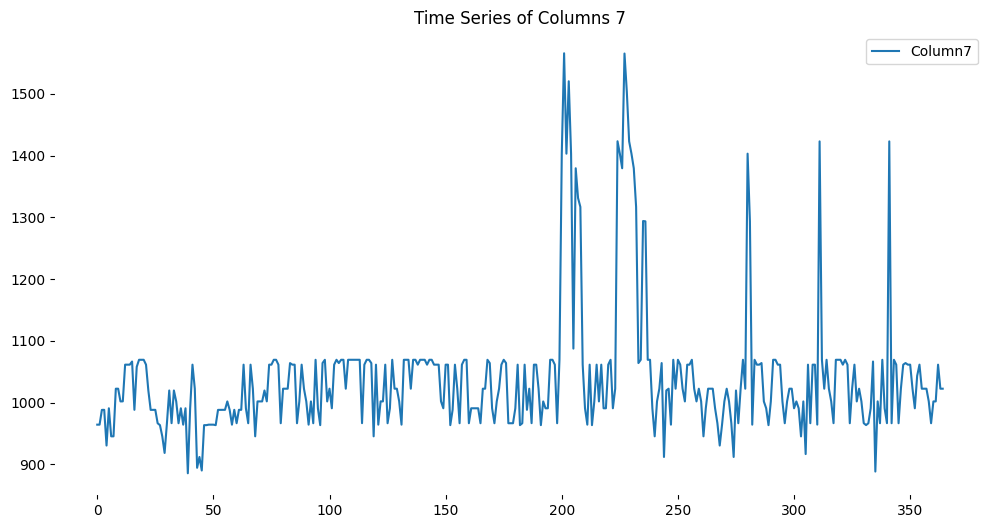

In [18]:
# biểu đồ thời gian
plt.figure(figsize=(12, 6))
plt.plot(df['7'], label='Column7')
plt.legend()
plt.title('Time Series of Columns 7')
plt.show()

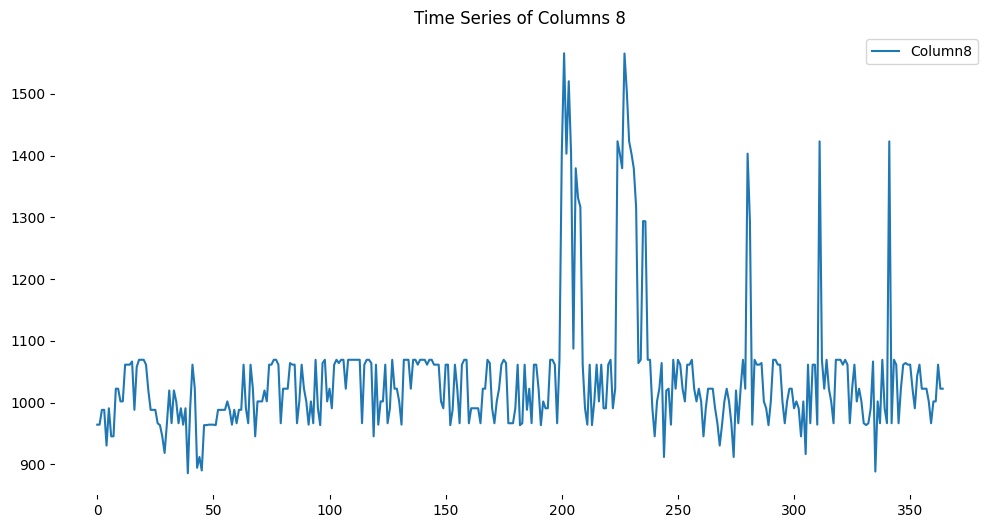

In [19]:
# biểu đồ thời gian
plt.figure(figsize=(12, 6))
plt.plot(df['8'], label='Column8')
plt.legend()
plt.title('Time Series of Columns 8')
plt.show()

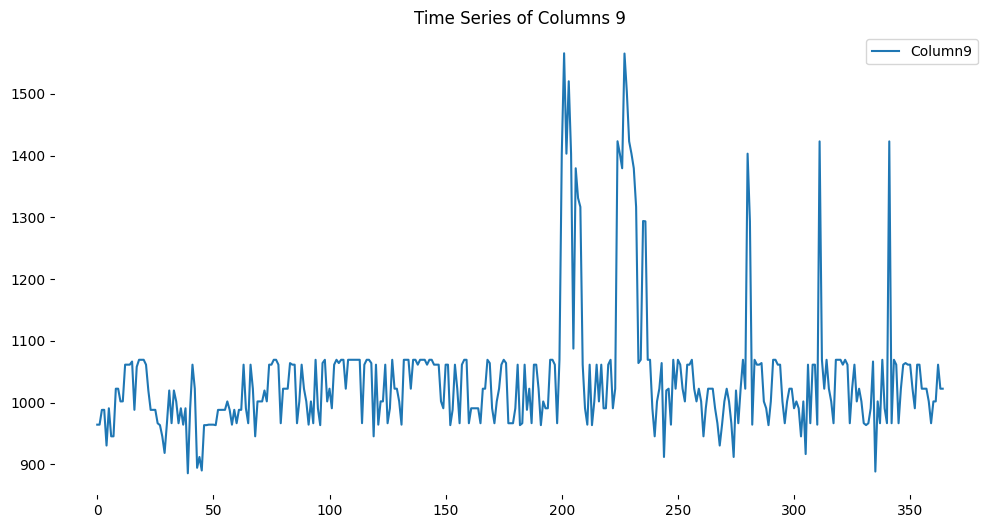

In [20]:
# biểu đồ thời gian
plt.figure(figsize=(12, 6))
plt.plot(df['9'], label='Column9')
plt.legend()
plt.title('Time Series of Columns 9')
plt.show()

## Kalman

In [33]:
from pykalman import KalmanFilter
# Lấy dữ liệu cột 7, 8, 9
observations = df[feats].values

# Định nghĩa mô hình Kalman Filter
kf = KalmanFilter(initial_state_mean=np.mean(observations, axis=0),
                  n_dim_obs=3)

# Ước lượng trạng thái
state_means, state_covariances = kf.em(observations).filter(observations)

In [34]:
# Tính toán các chỉ số đánh giá
for i, col in enumerate(feats):
    mse = mean_squared_error(observations[:, i], state_means[:, i])
    mae = mean_absolute_error(observations[:, i], state_means[:, i])
    rmse = np.sqrt(mse)
    print(f'Column {col} - MSE: {mse:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}')

Column 7 - MSE: 292.5848, MAE: 10.3005, RMSE: 17.1051
Column 8 - MSE: 292.5909, MAE: 10.3006, RMSE: 17.1053
Column 9 - MSE: 294.4686, MAE: 10.3378, RMSE: 17.1601


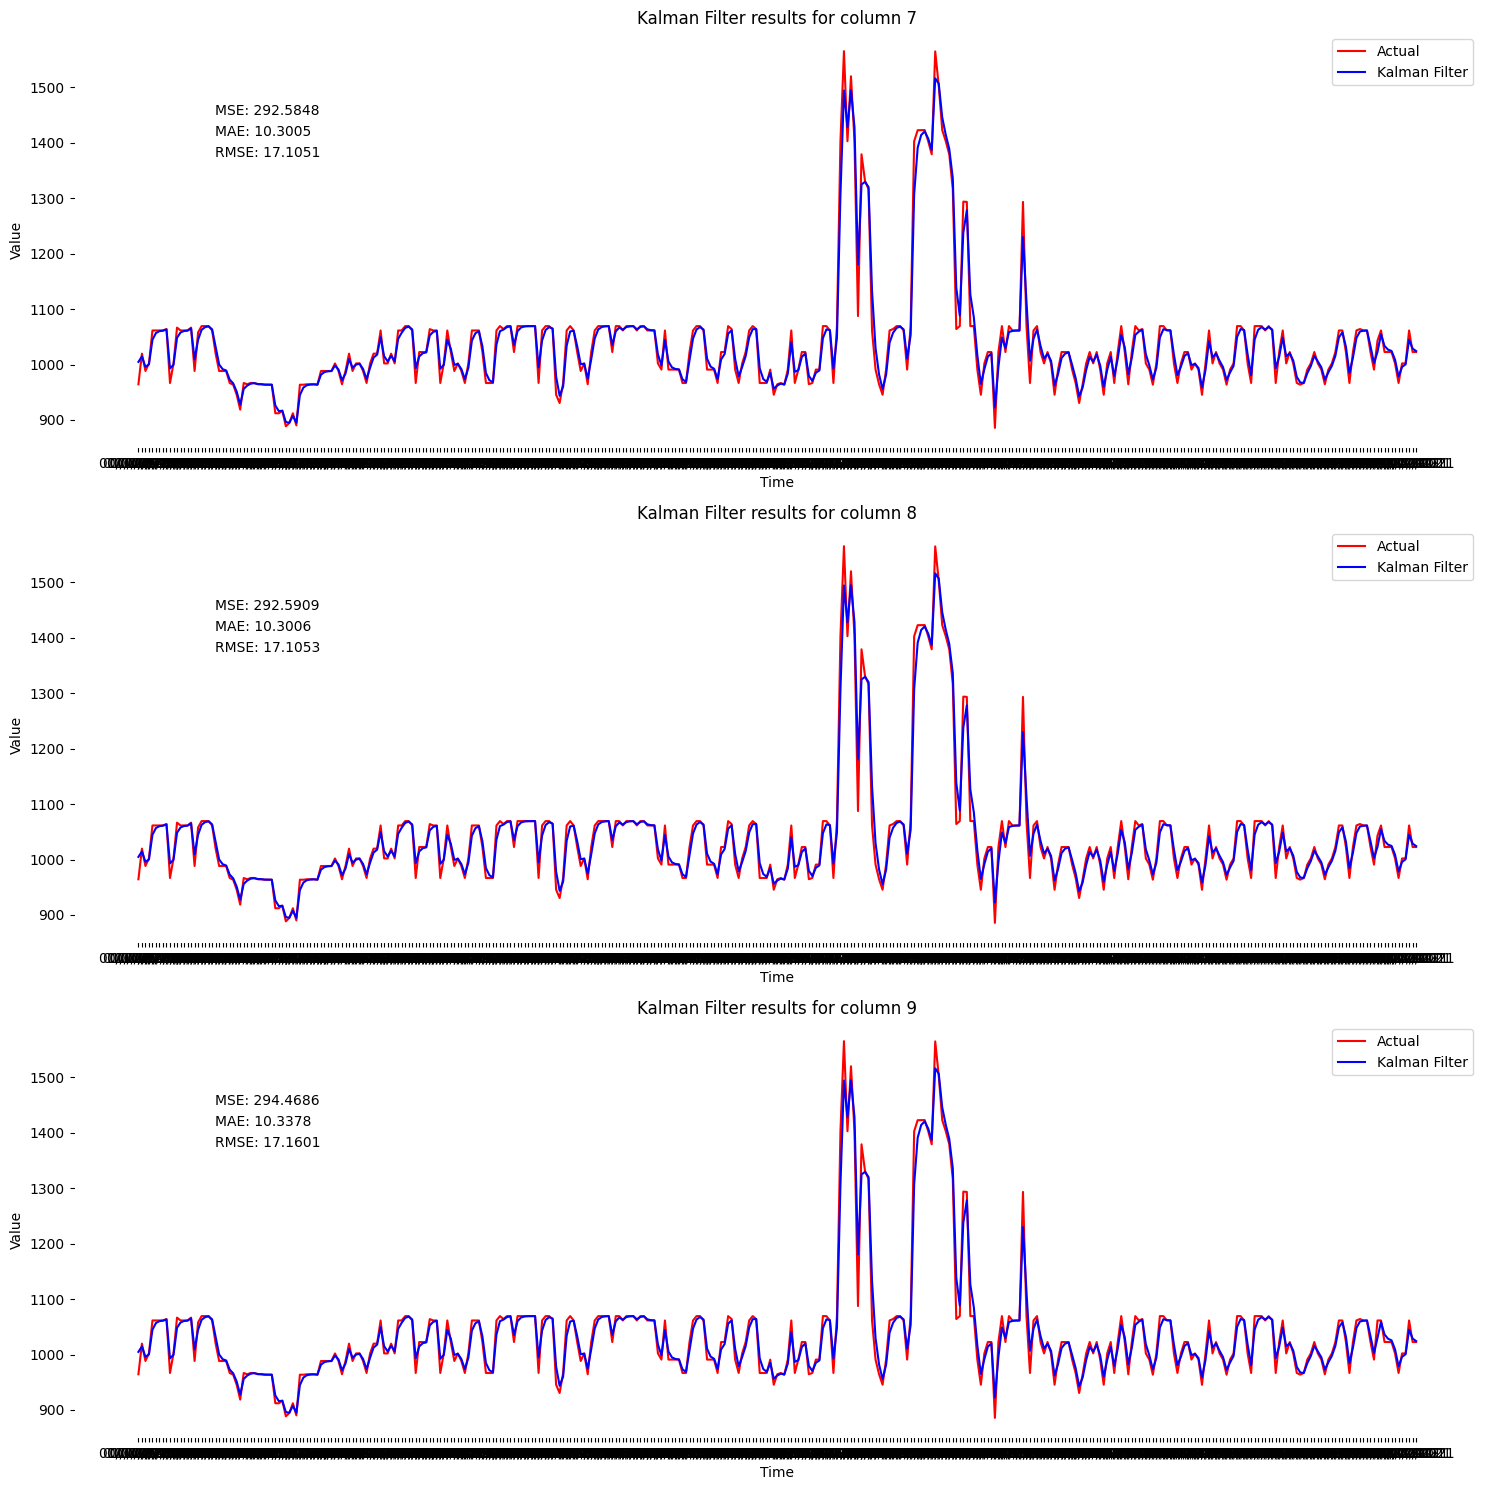

In [73]:
# Trực quan hóa kết quả cho từng cột
plt.figure(figsize=(15, 15))

for i, col in enumerate(feats):
    plt.subplot(len(feats), 1, i+1)
    plt.plot(df['Ngày'], observations[:, i], 'r', label='Actual')
    plt.plot(df['Ngày'], state_means[:, i], 'b', label='Kalman Filter')
    plt.title(f'Kalman Filter results for column {col}')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()

    # Tính toán các chỉ số đánh giá
    mse = mean_squared_error(observations[:, i], state_means[:, i])
    mae = mean_absolute_error(observations[:, i], state_means[:, i])
    rmse = np.sqrt(mse)
    plt.text(0.1, 0.8, f'MSE: {mse:.4f}', transform=plt.gca().transAxes)
    plt.text(0.1, 0.75, f'MAE: {mae:.4f}', transform=plt.gca().transAxes)
    plt.text(0.1, 0.7, f'RMSE: {rmse:.4f}', transform=plt.gca().transAxes)

plt.tight_layout()
plt.show()

## LSTM

In [52]:
import tensorflow as tf
from keras import Model
from keras.layers import Input, Dense, Dropout
from keras.layers import LSTM

In [63]:
from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
# scaler.fit(df[feats])
# Chuẩn hóa dữ liệu
scaler = MinMaxScaler(feature_range=(0, 1))
observations_scaled = scaler.fit_transform(observations)


In [64]:
# window_size = 15
# Hàm để chuẩn bị dữ liệu cho mô hình LSTM
def prepare_data(data, n_steps):
    X, y = [], []
    for i in range(len(data)-n_steps-1):
        X.append(data[i:(i+n_steps)])
        y.append(data[i+n_steps])
    return np.array(X), np.array(y)


In [44]:
# train_data = df[feats][:-test_size]
# train_data = scaler.transform(train_data)


In [65]:
# X_train = []
# y_train = []

# for i in range(window_size, len(train_data)):
#     X_train.append(train_data[i-window_size:i, 0])
#     y_train.append(train_data[i, 0])

# Số bước thời gian cho mỗi mẫu
n_steps = 7

# Chuẩn bị dữ liệu cho mô hình LSTM
X, y = prepare_data(observations_scaled, n_steps)

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [47]:
# test_data = df[feats][-test_size-window_size:]
# test_data = scaler.transform(test_data)

In [48]:
# X_test = []
# y_test = []

# for i in range(window_size, len(test_data)):
#     X_test.append(test_data[i-window_size:i, 0])
#     y_test.append(test_data[i, 0])

In [49]:
# X_train = np.array(X_train)
# X_test  = np.array(X_test)
# y_train = np.array(y_train)
# y_test  = np.array(y_test)

In [50]:
# X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
# X_test  = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
# y_train = np.reshape(y_train, (-1,1))
# y_test  = np.reshape(y_test, (-1,1))

In [53]:
# def define_model():
#     input1 = Input(shape=(window_size,1))
#     x = LSTM(units = 64)(input1)
#     x = Dense(32, activation='softmax')(x)
#     dnn_output = Dense(1)(x)

#     model = Model(inputs=input1, outputs=[dnn_output])
#     model.compile(loss='mean_squared_error', optimizer='Nadam')
#     model.summary()

#     return model

In [67]:
# model = define_model()
# history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.1, verbose=1)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Định nghĩa mô hình LSTM
model = Sequential()
model.add(LSTM(units=50, activation='relu', input_shape=(n_steps, len(feats))))
model.add(Dense(len(feats)))
model.compile(optimizer='adam', loss='mse')

# Huấn luyện mô hình
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), verbose=0)

# Dự đoán trên tập dữ liệu kiểm tra
y_pred = model.predict(X_test)

# Điều chỉnh lại dự đoán về scale ban đầu
y_pred_rescaled = scaler.inverse_transform(y_pred)
y_test_rescaled = scaler.inverse_transform(y_test)

c:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


In [69]:
# result = model.evaluate(X_test, y_test)
# y_pred = model.predict(X_test)

# Tính toán các chỉ số đánh giá cho LSTM
for i, col in enumerate(feats):
    mse_lstm = mean_squared_error(y_test_rescaled[:, i], y_pred_rescaled[:, i])
    mae_lstm = mean_absolute_error(y_test_rescaled[:, i], y_pred_rescaled[:, i])
    rmse_lstm = np.sqrt(mse_lstm)
    print(f'Column {col} - LSTM MSE: {mse_lstm:.4f}, LSTM MAE: {mae_lstm:.4f}, LSTM RMSE: {rmse_lstm:.4f}')

Column 7 - LSTM MSE: 1019.1096, LSTM MAE: 25.8820, LSTM RMSE: 31.9235
Column 8 - LSTM MSE: 1101.0815, LSTM MAE: 26.5470, LSTM RMSE: 33.1825
Column 9 - LSTM MSE: 1087.0277, LSTM MAE: 26.6294, LSTM RMSE: 32.9701


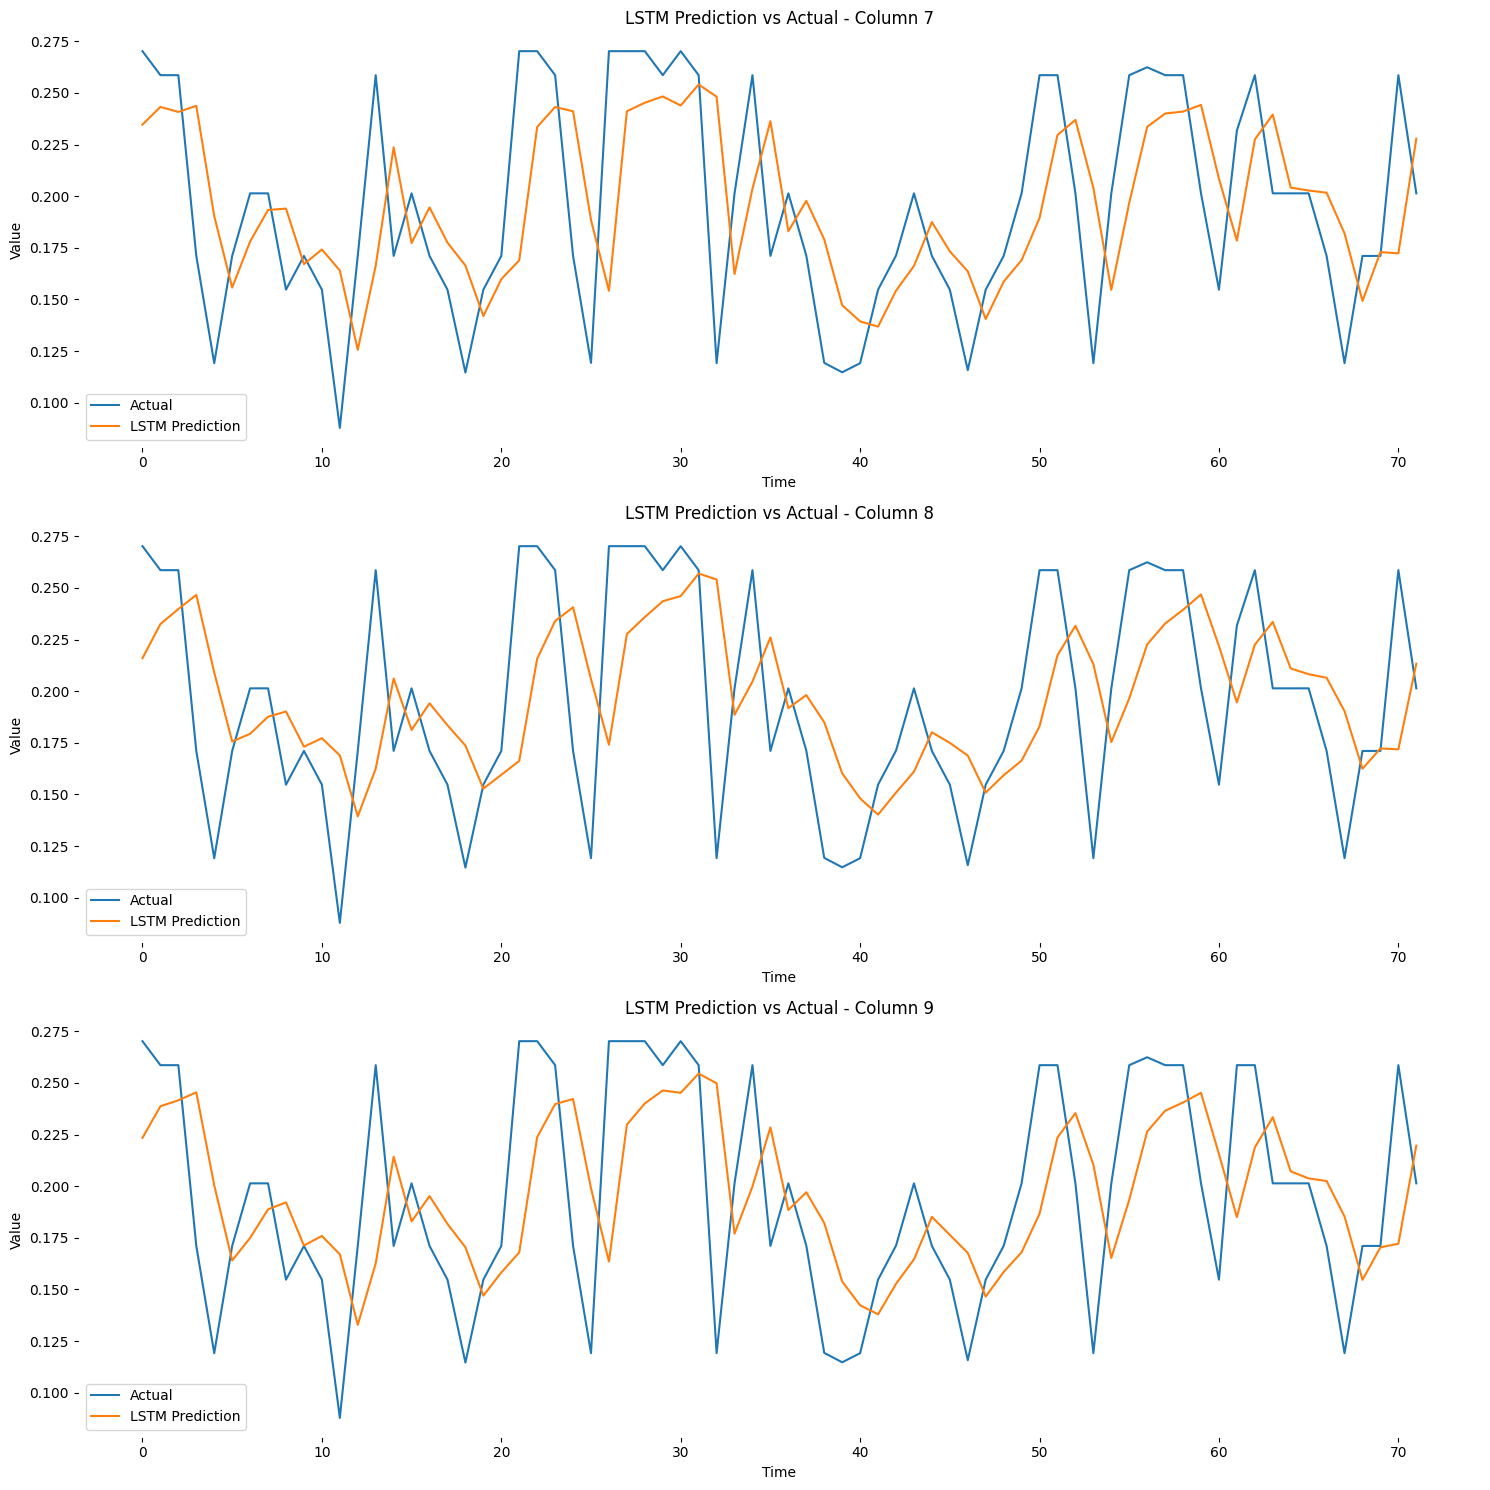

In [70]:
plt.figure(figsize=(15, 15))

for i, col in enumerate(feats):
    # Plotting predictions vs actual
    plt.subplot(3, 1, i+1)
    plt.plot(y_test[:, i], label='Actual')
    plt.plot(y_pred[:, i], label='LSTM Prediction')
    plt.title(f'LSTM Prediction vs Actual - Column {col}')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()

plt.tight_layout()
plt.show()